In [10]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.9.1
Num GPUs Available: 1


In [11]:
video_path = "video.mp4" 
cap = cv2.VideoCapture(video_path)
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_resized = cv2.resize(frame, (160, 120))
    frames.append(frame_resized / 255.0)

cap.release()
frames = np.array(frames)
print("Frames shape:", frames.shape)

Frames shape: (687, 120, 160, 3)


In [12]:
ann_model = Sequential([
    Flatten(input_shape=(120, 160, 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax') 
])

In [13]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(120, 160, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [14]:
# ANN on CPU
with tf.device('/CPU:0'):
    start = time.time()
    _ = ann_model.predict(frames, batch_size=1)
    ann_cpu_time = time.time() - start
    ann_cpu_fps = frames.shape[0] / ann_cpu_time
print(f"ANN on CPU: Time = {ann_cpu_time:.2f}s, FPS = {ann_cpu_fps:.2f}")

# CNN on CPU
with tf.device('/CPU:0'):
    start = time.time()
    _ = cnn_model.predict(frames, batch_size=1)
    cnn_cpu_time = time.time() - start
    cnn_cpu_fps = frames.shape[0] / cnn_cpu_time
print(f"CNN on CPU: Time = {cnn_cpu_time:.2f}s, FPS = {cnn_cpu_fps:.2f}")

# ANN on GPU
with tf.device('/GPU:0'):
    start = time.time()
    _ = ann_model.predict(frames, batch_size=1)
    ann_gpu_time = time.time() - start
    ann_gpu_fps = frames.shape[0] / ann_gpu_time
print(f"ANN on GPU: Time = {ann_gpu_time:.2f}s, FPS = {ann_gpu_fps:.2f}")

# CNN on GPU
with tf.device('/GPU:0'):
    start = time.time()
    _ = cnn_model.predict(frames, batch_size=1)
    cnn_gpu_time = time.time() - start
    cnn_gpu_fps = frames.shape[0] / cnn_gpu_time
print(f"CNN on GPU: Time = {cnn_gpu_time:.2f}s, FPS = {cnn_gpu_fps:.2f}")


687/687 [==============================] - 13s 18ms/step
ANN on CPU: Time = 12.98s, FPS = 52.94
687/687 [==============================] - 10s 15ms/step
CNN on CPU: Time = 10.24s, FPS = 67.11
687/687 [==============================] - 3s 1ms/step
ANN on GPU: Time = 2.91s, FPS = 235.93
687/687 [==============================] - 4s 1ms/step
CNN on GPU: Time = 4.70s, FPS = 146.28


In [15]:
results = pd.DataFrame({
    'Model': ['ANN', 'CNN', 'ANN', 'CNN'],
    'Device': ['CPU', 'CPU', 'GPU', 'GPU'],
    'Time (s)': [ann_cpu_time, cnn_cpu_time, ann_gpu_time, cnn_gpu_time],
    'FPS': [ann_cpu_fps, cnn_cpu_fps, ann_gpu_fps, cnn_gpu_fps]
})
print(results)

  Model Device   Time (s)         FPS
0   ANN    CPU  12.977628   52.937254
1   CNN    CPU  10.236545   67.112489
2   ANN    GPU   2.911881  235.929993
3   CNN    GPU   4.696623  146.275310


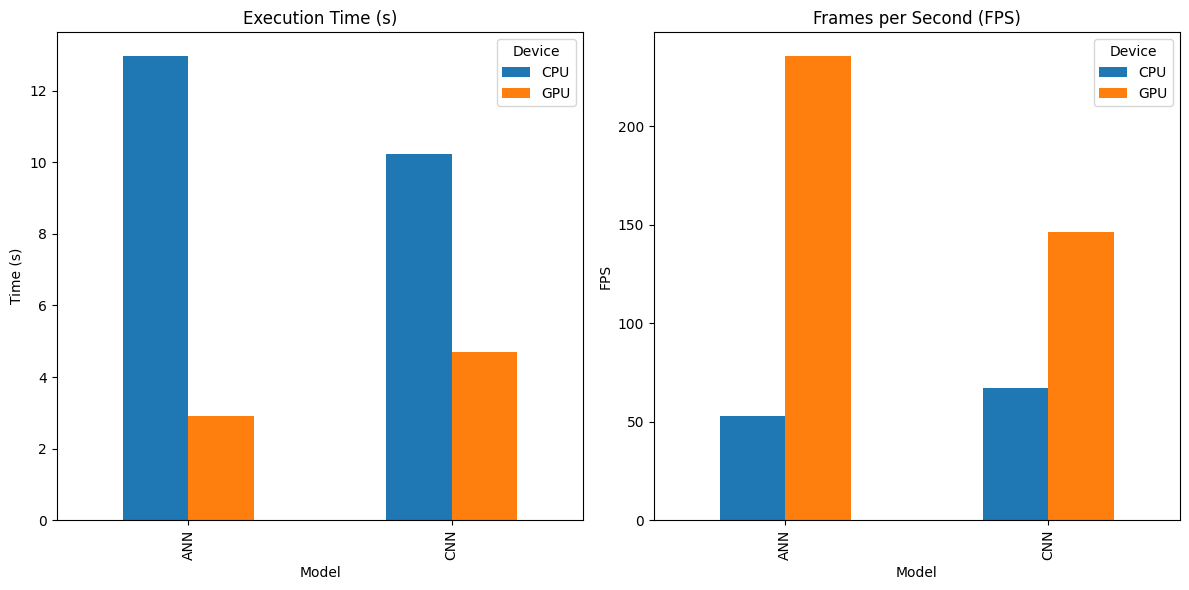

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

results.pivot(index="Model", columns="Device", values="Time (s)").plot(kind='bar', ax=ax[0])
ax[0].set_title("Execution Time (s)")
ax[0].set_ylabel("Time (s)")

results.pivot(index="Model", columns="Device", values="FPS").plot(kind='bar', ax=ax[1])
ax[1].set_title("Frames per Second (FPS)")
ax[1].set_ylabel("FPS")

plt.tight_layout()
plt.show()